In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [9]:
from torchvision import transforms
import random

augmentations = False

if augmentations:
    transform = transforms.Compose([
        transforms.Resize((200, 200)),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0, saturation=0, hue=0)], 0.25),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0)], 0.25),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0, contrast=0, saturation=0.2, hue=0)], 0.25),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.2)], 0.25),
        transforms.RandomApply([
            transforms.GaussianBlur(3)], 0.25),
        transforms.RandomAdjustSharpness(random.uniform(0, 2), 0.25)
    ])
else:
    transform = transforms.Compose([
        transforms.Resize((200, 200))
    ])
    
transformations_testing = transforms.Compose([
        transforms.Resize((200, 200))
])

In [10]:
#dataset_str = 'cropped_images'
#dataset_str = 'cropped_processed_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'
#dataset_str = 'cropped_rotated_processed_images_3'
#dataset_str = 'cropped_rotated_processed_images_4'
dataset_str = "cropped_rotated_processed_images_5"
#dataset_str = "cropped_rotated_processed_images_6"

#dataset_str = 'cropped_images_extended'
#dataset_str = 'cropped_rotated_images_extended'
#dataset_str = "cropped_rotated_processed_images_5_extended"

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transformations_testing, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [11]:
if augmentations:
    dataset_str = "augmented_" + dataset_str

In [12]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [13]:
model = model.to(device)

In [14]:
results_dir = 'results/'

In [15]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [16]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                print(
                    f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 120 / 196 with accuracy 61.22
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 161 / 196 with accuracy 82.14
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 175 / 196 with accuracy 89.29
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 161 / 196 with accuracy 82.14
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 178 / 196 with accuracy 90.82
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 178 / 196 with accuracy 90.82
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 176 / 196 with accuracy 89.80
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 180 / 196 with accuracy 91.84
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 182 / 196 with accuracy 92.86
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 184 / 196 with accuracy 93.88
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 183 / 196 with accuracy 93.37
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 182 / 196 with accuracy 92.86
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 184 / 196 with accuracy 93.88
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 182 / 196 with accuracy 92.86
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 182 / 196 with accuracy 92.86
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 177 / 196 with accuracy 90.31
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 172 / 196 with accuracy 87.76
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 183 / 196 with accuracy 93.37
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 179 / 196 with accuracy 91.33
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 174 / 196 with accuracy 88.78


In [17]:
csvfile.close()

In [18]:
best_acc

93.87755102040816

In [19]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [20]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [21]:
testloader = DataLoader(testing_dataset, shuffle=False, batch_size=32, num_workers=0)
preds = []
y_true = []
for x, y in testloader:
    scores = model(x)
    predictions = scores.argmax(1)
    preds.append(predictions)
    y_true.append(y)

preds = torch.cat(preds)
y_true = torch.cat(y_true)

In [22]:
preds

tensor([0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6,
        6, 6, 6, 6])

In [23]:
y_true

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])

In [24]:
import pandas as pd

In [25]:
df = pd.DataFrame({'predictions': preds.cpu().numpy(), 'y_true': y_true.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,0,0
1,4,0
2,0,0
3,0,0
4,0,0
...,...,...
191,6,6
192,6,6
193,6,6
194,6,6


In [26]:
preds = df['predictions'].values
preds

array([0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2, 6, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6],
      dtype=int64)

In [27]:
y_true = df['y_true'].values
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
      dtype=int64)

In [28]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [29]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [30]:
results_dict

{'A': [18, 23],
 'B': [22, 23],
 'C': [32, 35],
 'D': [31, 32],
 'E': [25, 26],
 'F': [24, 24],
 'G': [32, 33]}

In [31]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,18,23
B,22,23
C,32,35
D,31,32
E,25,26
F,24,24
G,32,33


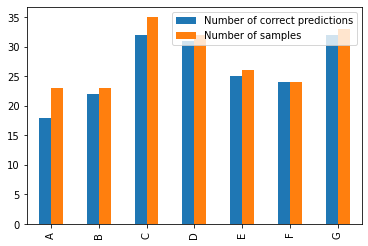

In [32]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [34]:
print(confusion_matrix(y_true, preds))

[[18  0  0  1  4  0  0]
 [ 0 22  0  0  0  0  1]
 [ 0  0 32  0  0  0  3]
 [ 0  0  0 31  1  0  0]
 [ 0  0  1  0 25  0  0]
 [ 0  0  0  0  0 24  0]
 [ 0  1  0  0  0  0 32]]


In [35]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.9387755102040817

In [36]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [37]:
precision = precision_score(y_true, preds, average=None)
precision

array([1.        , 0.95652174, 0.96969697, 0.96875   , 0.83333333,
       1.        , 0.88888889])

In [38]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.7826087 , 0.95652174, 0.91428571, 0.96875   , 0.96153846,
       1.        , 0.96969697])

In [39]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.87804878, 0.95652174, 0.94117647, 0.96875   , 0.89285714,
       1.        , 0.92753623])

In [40]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,1.000000,0.782609,0.878049
B,0.956522,0.956522,0.956522
C,0.969697,0.914286,0.941176
D,0.968750,0.968750,0.968750
E,0.833333,0.961538,0.892857
F,1.000000,1.000000,1.000000
G,0.888889,0.969697,0.927536


<AxesSubplot:>

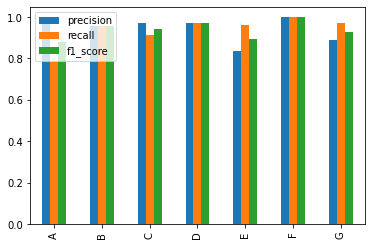

In [41]:
df.plot.bar()